<a href="https://colab.research.google.com/github/ed-chin-git/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/DS_Unit_1_Sprint_Challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 1 Sprint Challenge 4

## Exploring Data, Testing Hypotheses

In this sprint challenge you will look at a dataset of people being approved or rejected for credit.

https://archive.ics.uci.edu/ml/datasets/Credit+Approval

Data Set Information: This file concerns credit card applications. All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data. This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values. There are also a few missing values.

Attribute Information:
- A1: b, a.
- A2: continuous.
- A3: continuous.
- A4: u, y, l, t.
- A5: g, p, gg.
- A6: c, d, cc, i, j, k, m, r, q, w, x, e, aa, ff.
- A7: v, h, bb, j, n, z, dd, ff, o.
- A8: continuous.
- A9: t, f.
- A10: t, f.
- A11: continuous.
- A12: t, f.
- A13: g, p, s.
- A14: continuous.
- A15: continuous.
- A16: +,- (class attribute)

Yes, most of that doesn't mean anything. A16 (the class attribute) is the most interesting, as it separates the 307 approved cases from the 383 rejected cases. The remaining variables have been obfuscated for privacy - a challenge you may have to deal with in your data science career.

Sprint challenges are evaluated based on satisfactory completion of each part. It is suggested you work through it in order, getting each aspect reasonably working, before trying to deeply explore, iterate, or refine any given step. Once you get to the end, if you want to go back and improve things, go for it!

## Part 1 - Load and validate the data

- Load the data as a `pandas` data frame.
- Validate that it has the appropriate number of observations (you can check the raw file, and also read the dataset description from UCI).
- UCI says there should be missing data - check, and if necessary change the data so pandas recognizes it as na
- Make sure that the loaded features are of the types described above (continuous values should be treated as float), and correct as necessary

This is review, but skills that you'll use at the start of any data exploration. Further, you may have to do some investigation to figure out which file to load from - that is part of the puzzle.

###Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

### Load DataFrame

In [0]:
data_url='https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
df=pd.read_csv(data_url,header=None)

### Validate Number of Observations

In [245]:
# VaLIDATE number of obervations should = 690 (307+383)
df.shape

(690, 16)

### Handle Missing Data

In [0]:
# rename the columns/Attributes
column_names = {0 :"A1",
                1 : "A2",
                2 : "A3",
                3 : "A4",
                4 : "A5",
                5 : "A6",
                6 : "A7",
                7 : "A8",
                8 : "A9",
                9 : "A10",
                10 : "A11",
                11 : "A12",
                12 : "A13",
                13 : "A14",
                14 : "A15",
                15 : "A16"}
df.rename(column_names, axis='columns', inplace=True)

   ### Encode and Verify missing data 
    37 cases (5%) have one or more missing values.  The missing
    values from particular attributes are:
            A1:  12
            A2:  12
            A4:   6
            A5:   6
            A6:   9
            A7:   9
            A14: 13

In [248]:
df.replace(to_replace='?', value=np.nan, inplace=True) # replace ? with Nan

df.isnull().sum()

A1     12
A2     12
A3      0
A4      6
A5      6
A6      9
A7      9
A8      0
A9      0
A10     0
A11     0
A12     0
A13     0
A14    13
A15     0
A16     0
dtype: int64

## Part 2 - Exploring data, Testing hypotheses

The only thing we really know about this data is that A16 is the class label. Besides that, we have 6 continuous (float) features and 9 categorical features.

Explore the data: you can use whatever approach (tables, utility functions, visualizations) to get an impression of the distributions and relationships of the variables. In general, your goal is to understand how the features are different when grouped by the two class labels (`+` and `-`).

For the 6 continuous features, how are they different when split between the two class labels? Choose two features to run t-tests (again split by class label) - specifically, select one feature that is *extremely* different between the classes, and another feature that is notably less different (though perhaps still "statistically significantly" different). You may have to explore more than two features to do this.

For the categorical features, explore by creating "cross tabs" between them and the class label, and apply the Chi-squared test to them. There are 9 categorical features - as with the t-test, try to find one where the Chi-squared test returns an extreme result (rejecting the null that the data are independent), and one where it is less extreme.

**NOTE** - "less extreme" just means smaller test statistic/larger p-value. Even the least extreme differences may be strongly statistically significant.

Your *main* goal is the hypothesis tests, so don't spend too much time on the exploration/visualization piece. That is just a means to an end. This is challenging, so manage your time and aim for a baseline of at least running two t-tests and two Chi-squared tests before polishing. And don't forget to answer the questions in part 3, even if your results in this part aren't what you want them to be.

### Drop observations with Nans

In [0]:
df.dropna(subset=['A2', 'A3','A8','A11','A14','A15',], inplace=True)

In [0]:
# Create 2 Sample sets  
df_approved = df[df.A16 == "+"]
df_denied = df[df.A16 == "-"]

In [262]:
df_denied.shape

(367, 16)

In [0]:
df_denied.head(700)

AxesSubplot(0.125,0.125;0.775x0.755)


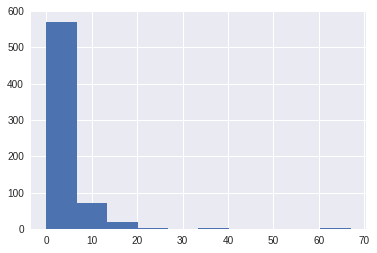

In [207]:
print(df.A11.hist())

AxesSubplot(0.125,0.125;0.775x0.755)


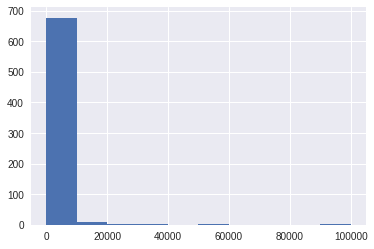

In [179]:
print(df.A15.hist())

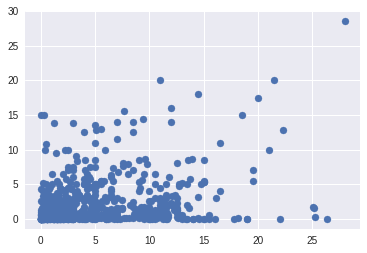

In [180]:
print(plt.scatter(df['A3'], df['A8']))

In [208]:
df_approved.describe()

,A3,A8,A11,A15
count,299.000000,299.000000,299.000000,299.000000
mean,5.980167,3.464565,4.682274,1994.397993
std,5.490187,4.151068,6.374976,7623.847320
min,0.000000,0.000000,0.000000,0.000000
25%,1.500000,0.750000,0.000000,0.000000
50%,4.500000,2.000000,3.000000,234.000000
75%,9.582500,5.000000,7.000000,1209.000000
max,28.000000,28.500000,67.000000,100000.000000


In [209]:
df_denied.describe()

,A3,A8,A11,A15
count,367.000000,367.000000,367.000000,367.000000
mean,3.835014,1.210245,0.648501,187.280654
std,4.348158,2.010897,1.934485,626.046320
min,0.000000,0.000000,0.000000,0.000000
25%,0.835000,0.125000,0.000000,0.000000
50%,2.165000,0.415000,0.000000,1.000000
75%,5.000000,1.500000,0.000000,67.500000
max,26.335000,13.875000,20.000000,5552.000000


In [0]:
print(df.A3.hist())

AxesSubplot(0.125,0.125;0.775x0.755)


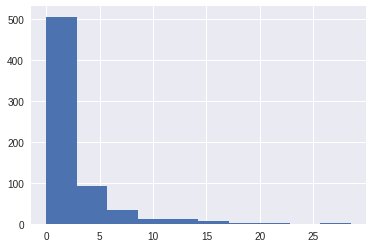

In [210]:
print(df.A8.hist())

### Explore

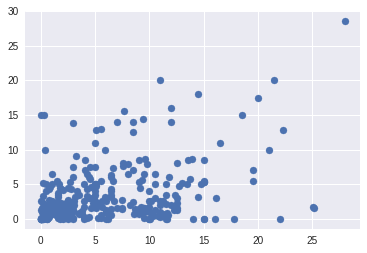

In [224]:
print(plt.scatter(df_approved['A3'], df_approved['A8']))

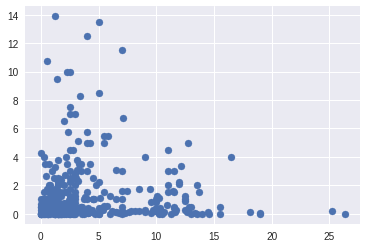

In [225]:
print(plt.scatter(df_denied['A3'], df_denied['A8']))


### T-tests

For the 6 continuous features, how are they different when split between the two class labels? Choose two features to run t-tests (again split by class label) - specifically, select one feature that is extremely different between the classes, and another feature that is notably less different (though perhaps still "statistically significantly" different). You may have to explore more than two features to do this.

- A2: continuous.
- A3: continuous.
- A8: continuous.
- A11: continuous.
- A14: continuous.
- A15: continuous.

In [276]:
print("Issues with p-value < 0.01")

columns=['A8','A11','A3','A15']

#for col in df_approved.columns.values:
for col in columns:
    statistics, pvalue = stats.ttest_ind(df_approved[col], 
                          df_denied[col], 
                          nan_policy='omit',
                          equal_var=True)
    if pvalue < 0.05:
      print("{:>40} {:10.3} {:>15.2}".format(col, statistics, pvalue))

Issues with p-value < 0.01
                                      A8       9.17           6e-19
                                     A11       11.5         5.3e-28
                                      A3       5.63         2.7e-08
                                     A15       4.52         7.2e-06


### Chi squared Test

In [277]:
print("Issues with p-value < 0.01")

columns=['A8','A11','A3','A15']

#for col in df_approved.columns.values:
for col in columns:
  statistics, pvalue = stats.chisquare(df_approved[col])
  if pvalue < 0.05:
    print("{:>40} {:10.3} {:>15.2}".format(col, statistics, pvalue))

Issues with p-value < 0.01
                                      A8   1.48e+03        3.9e-156
                                     A11   2.59e+03             0.0
                                      A3    1.5e+03        1.3e-159
                                     A15   8.68e+06             0.0


In [0]:
pd.set_option("display.max_rows", len(df))
df_approved.head(700)

## Part 3 - Analysis and Interpretation

Now that you've looked at the data, answer the following questions:

- Interpret and explain the two t-tests you ran - what do they tell you about the relationships between the continuous features you selected and the class labels?
- Interpret and explain the two Chi-squared tests you ran - what do they tell you about the relationships between the categorical features you selected and the class labels?
- What was the most challenging part of this sprint challenge?

Answer with text, but feel free to intersperse example code/results or refer to it from earlier.

### Encode Ordinals  t/f  becomes 1/0

In [0]:
#df.A9.replace(to_replace='t', value=1, inplace=True)  #  encode t = 1
#df.A9.replace(to_replace='f', value=0, inplace=True)  # encode f = 0

#df.A10.replace(to_replace='t', value=1, inplace=True)  #  encode t = 1
#df.A10.replace(to_replace='f', value=0, inplace=True)  # encode f = 0

#df.A12.replace(to_replace='t', value=1, inplace=True)  #  encode t = 1
#df.A12.replace(to_replace='f', value=0, inplace=True)  # encode f = 0

In [190]:
df.isnull().sum()

A1     12
A2     12
A3      0
A4      6
A5      6
A6      9
A7      9
A8      0
A9      0
A10     0
A11     0
A12     0
A13     0
A14    13
A15     0
A16     0
dtype: int64

*Your words here!*